# ANALISANDO E PREPARANDO OS DADOS PARA TREINAMENTO DO MODELO

In [58]:
try:
    import sys
    sys.path.append('/var/lang/lib/python37.zip')
    sys.path.append('/var/lang/lib/python3.7')
    sys.path.append('/var/lang/lib/python3.7/lib-dynload')
    sys.path.append('/var/lang/lib/python3.7/site-packages')
    sys.path.remove('/opt/.sagemakerinternal/conda/lib/python3.7/site-packages')
except:
    pass

# 1. Parametros 

In [59]:
#Nome do trabalho
ModelName = 'treinamento_validacao_modelo2'

#Configurando a variavel target do dataset
VarTarget = 'target'
VarId = 'id'

# Configurando o nome do bucket criado no AWS S3
bucket = 'cleversonadao'

In [60]:
import json
import pandas as pd
import numpy as np
import boto3
import os
import sweetviz as sv
from io import StringIO
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings
import random
import sagemaker
from sagemaker import get_execution_role
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. Importando os dados do arquivo CSV

## Para mais detalhes sobre a base do Heart Disease, consulte seu [link](https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset) no Kaggle

In [61]:
dataprep_df = pd.read_csv('./Heart/heart.csv')
dataprep_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


# 3. Criando coluna id para facilitar o manuseio do dataset

In [62]:
dataprep_df['id'] = dataprep_df.index+1
dataprep_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,id
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,1
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,2
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,3
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,4
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1,1021
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0,1022
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0,1023
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1,1024


## 4. Analasindo a distribuicao do dataset em relacao a varivel target 

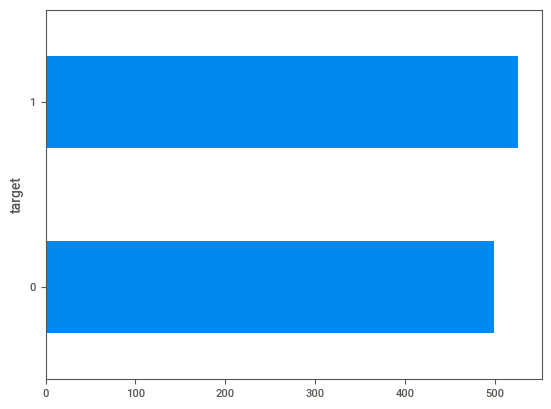

In [63]:
dataprep_df.groupby([VarTarget])[VarId].count().plot(kind='barh')

# 5. Utilizando a biblioteca Sweetviz para iniciar a analise exploratoria dos dados

                                             |          | [  0%]   00:00 -> (? left)


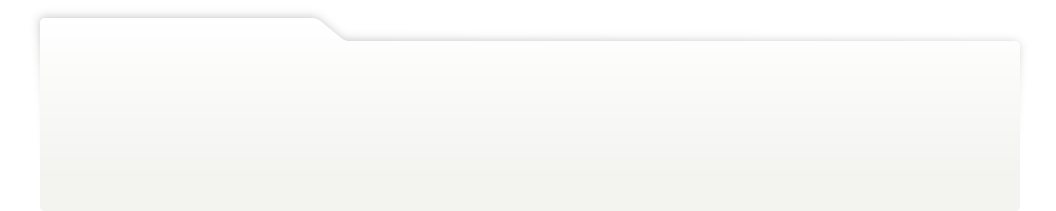
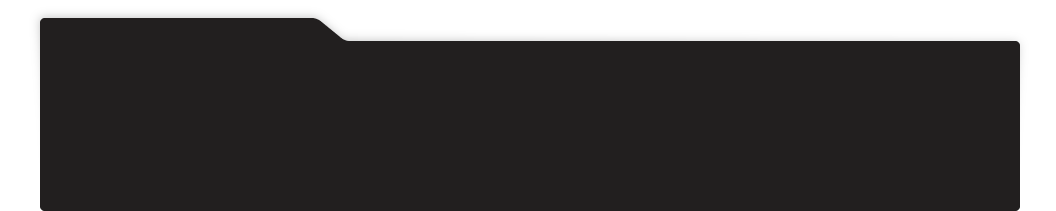
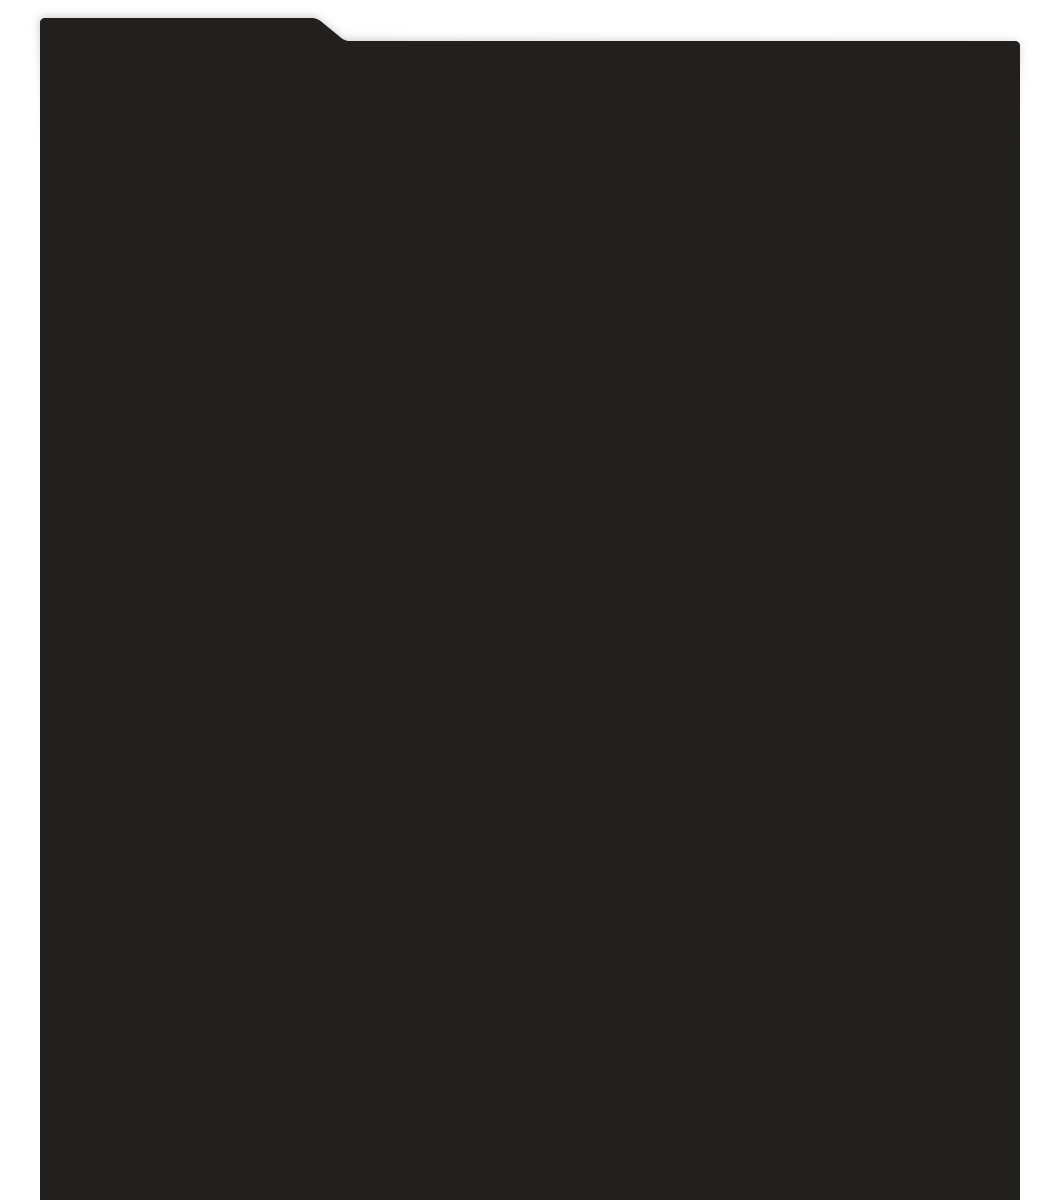
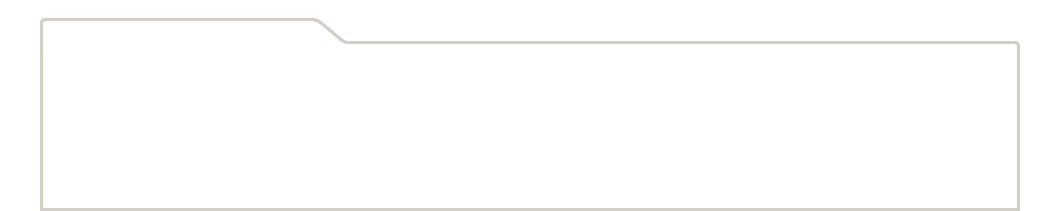
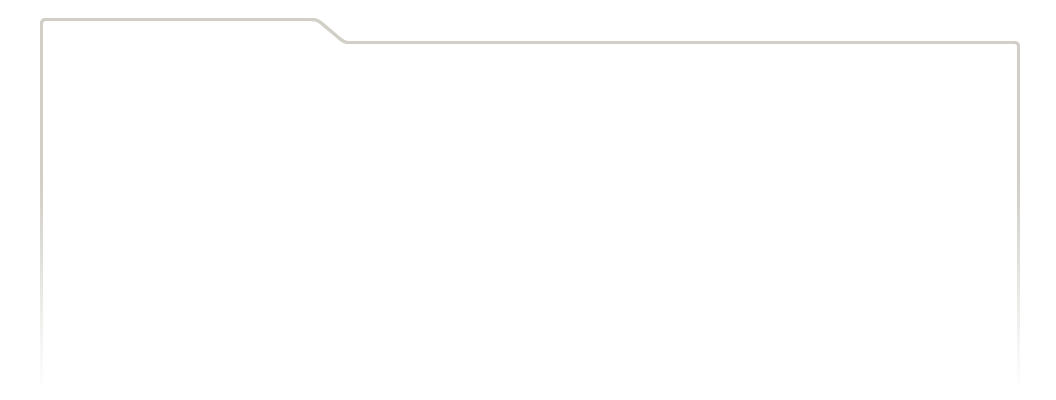
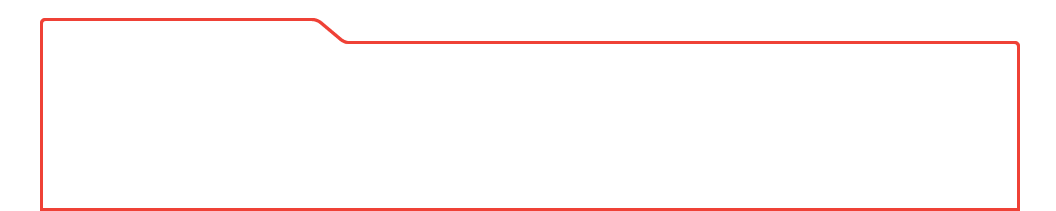
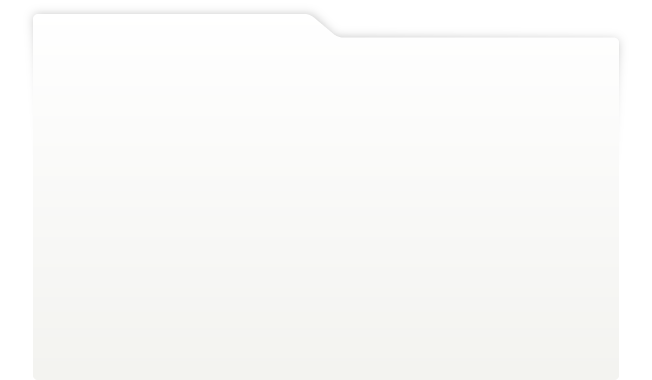
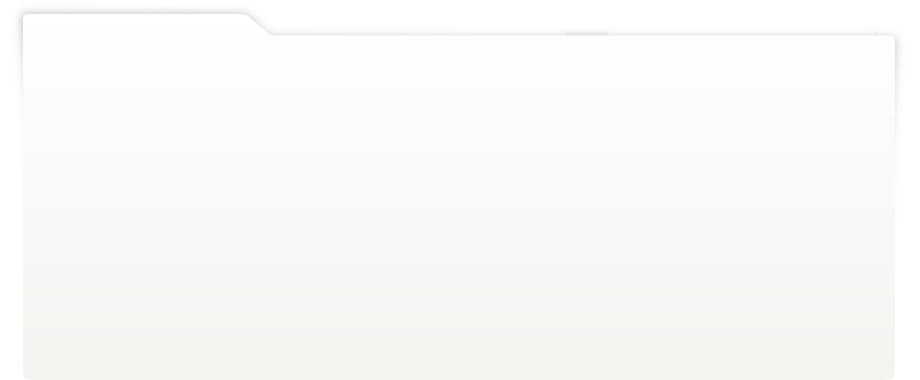
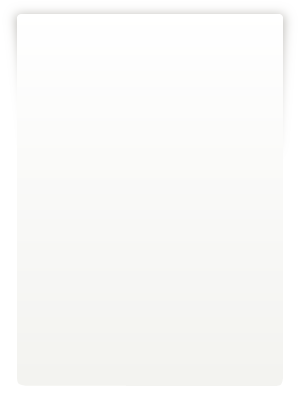
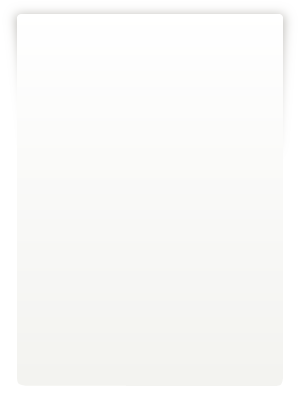
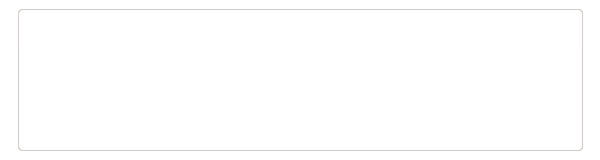
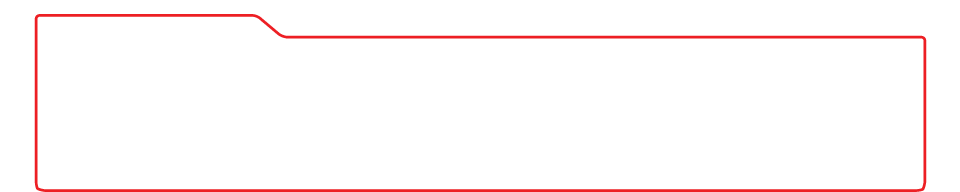
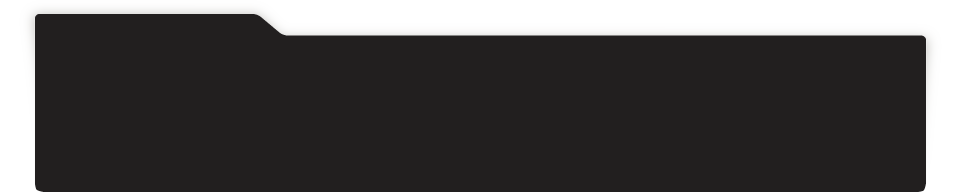
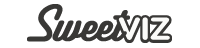
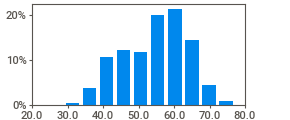
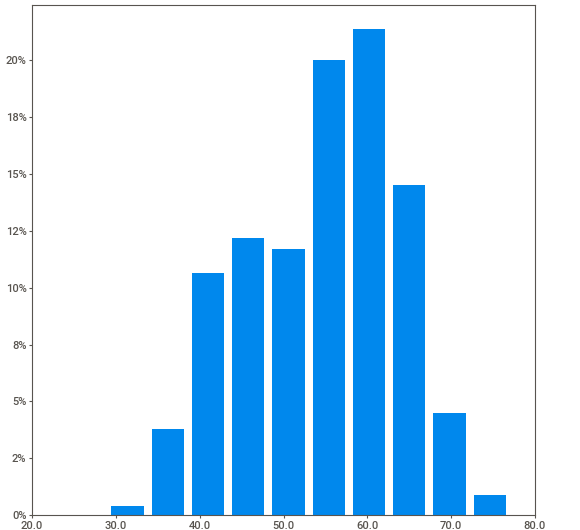
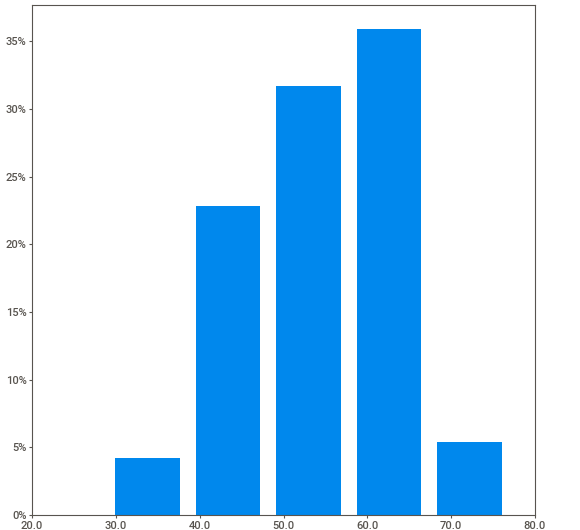
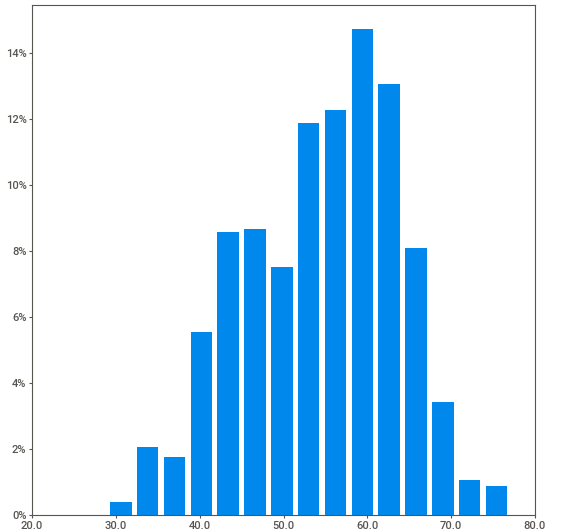
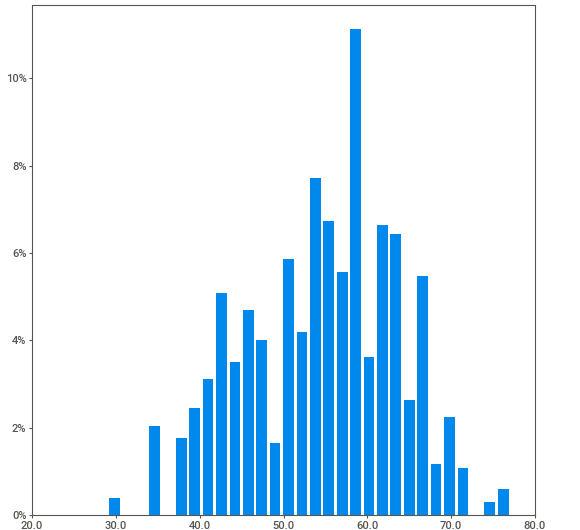
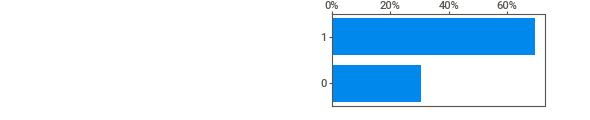
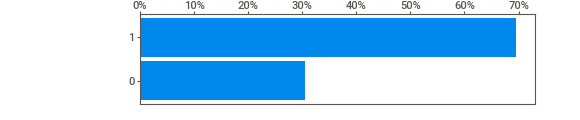
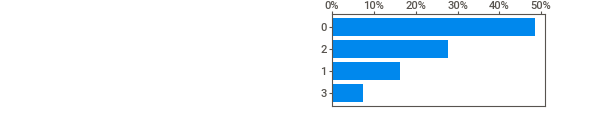
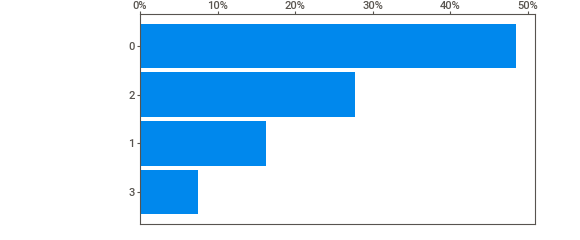
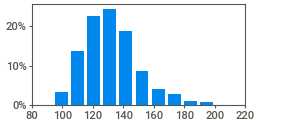
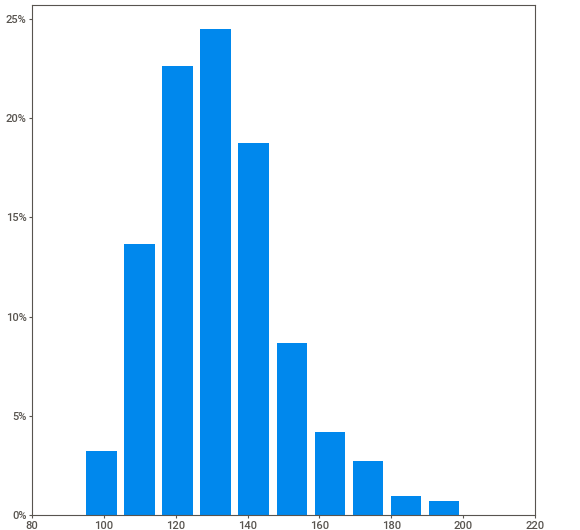
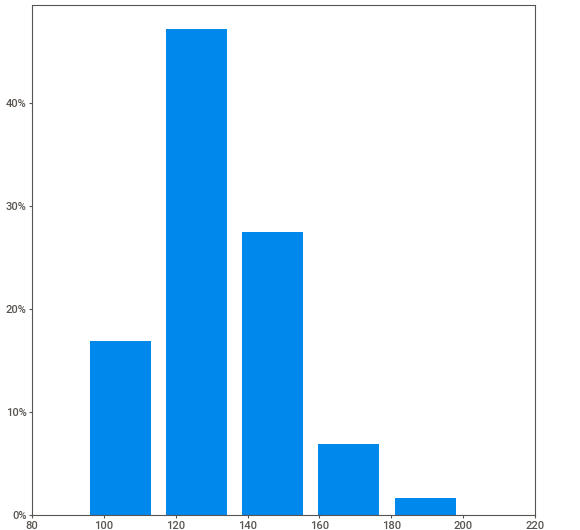
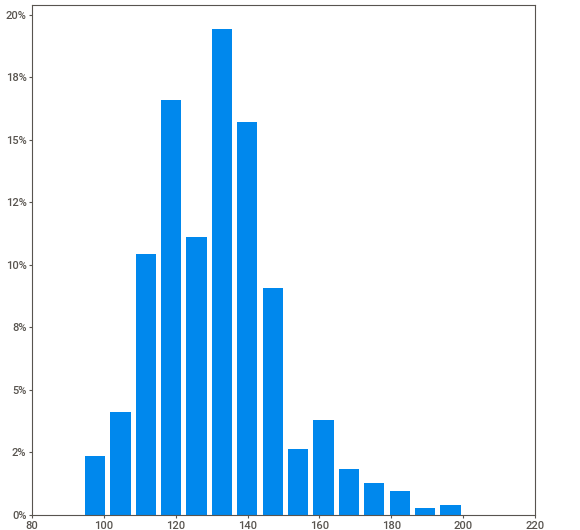
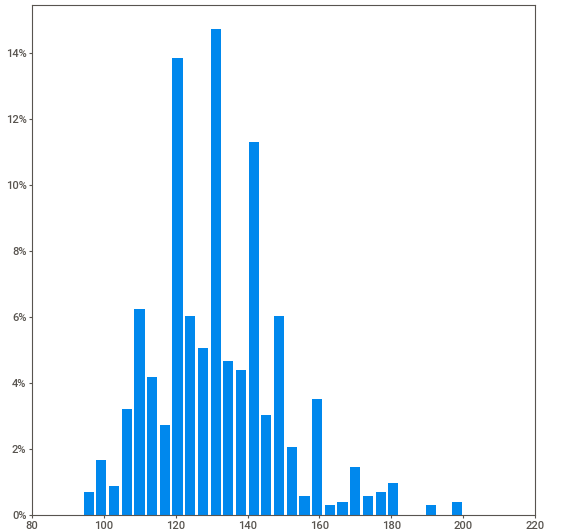
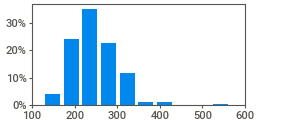
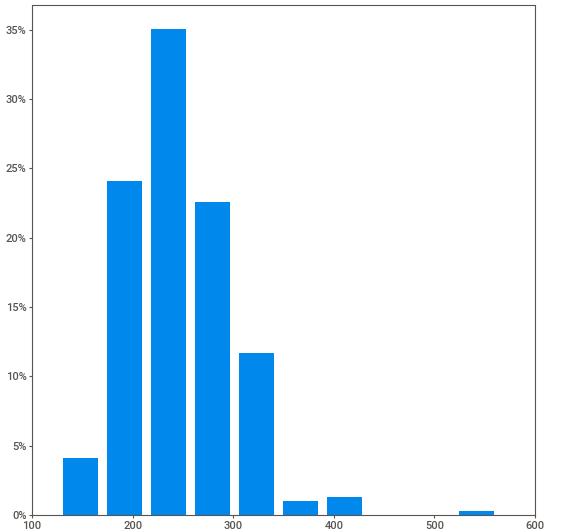
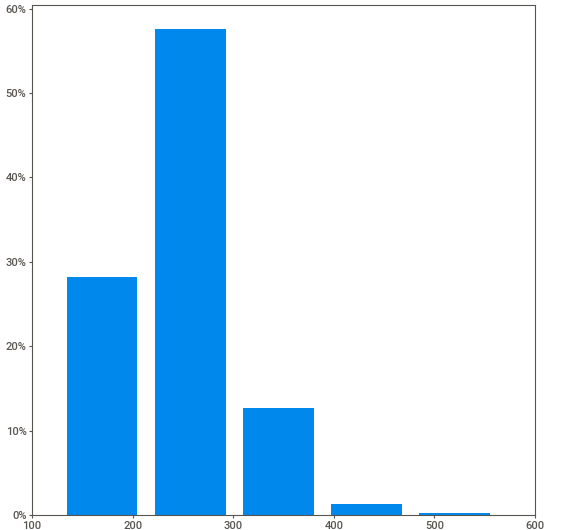
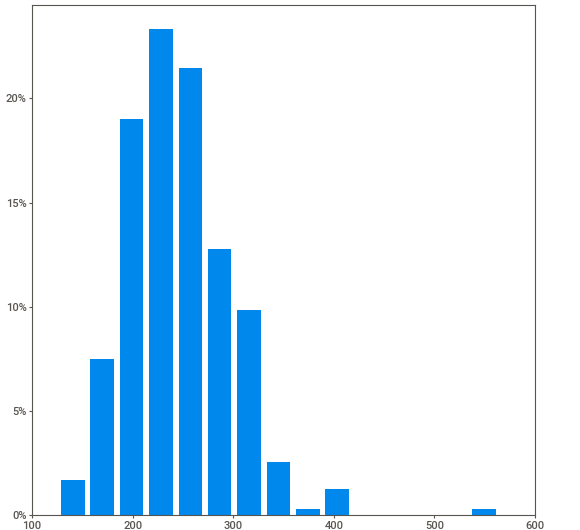
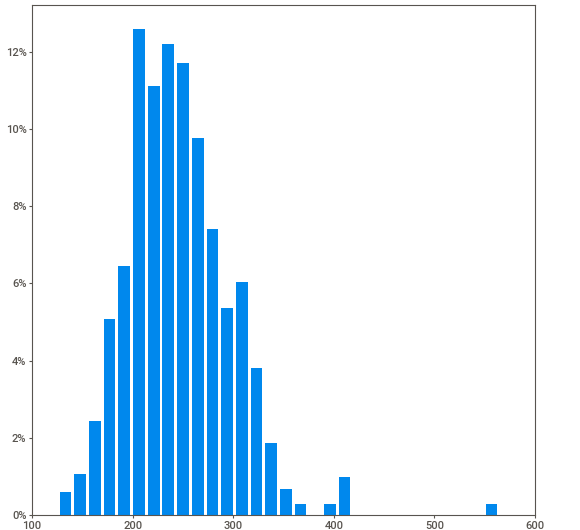
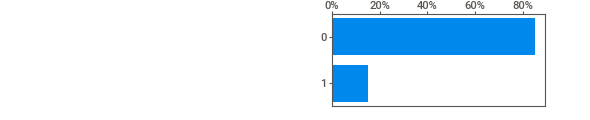
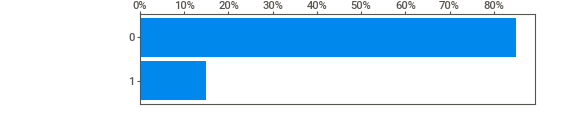
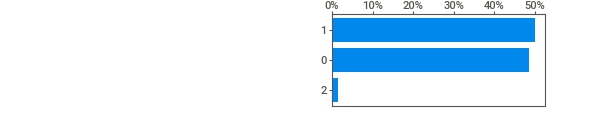
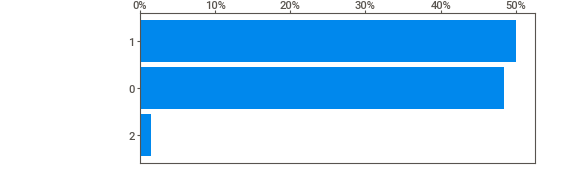
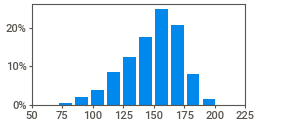
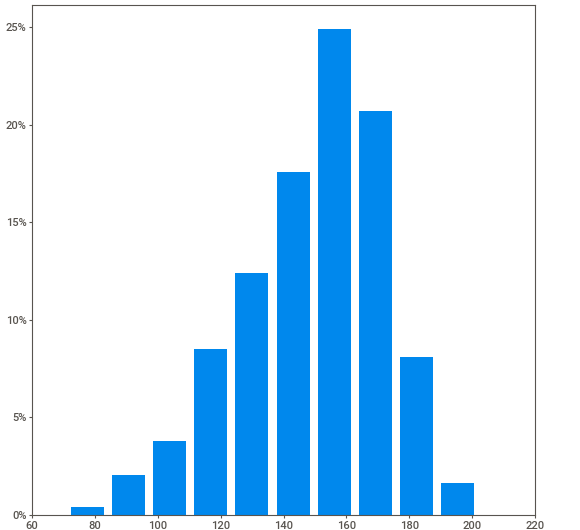
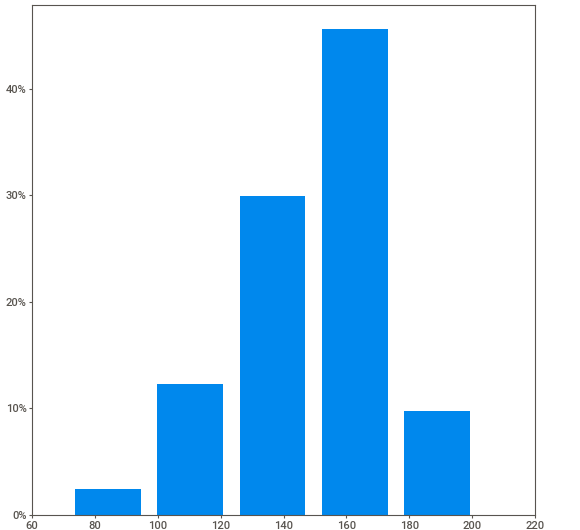
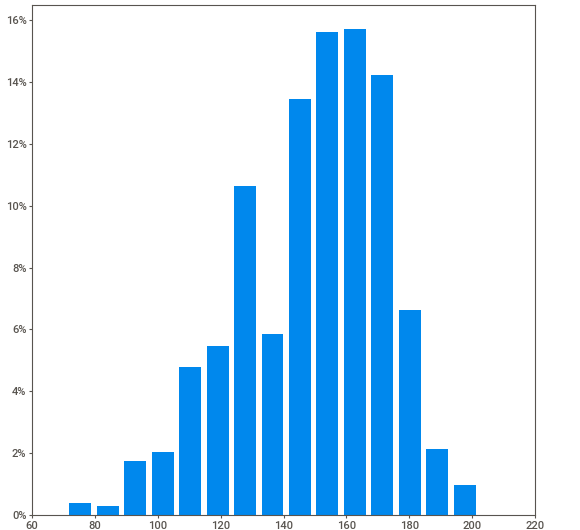
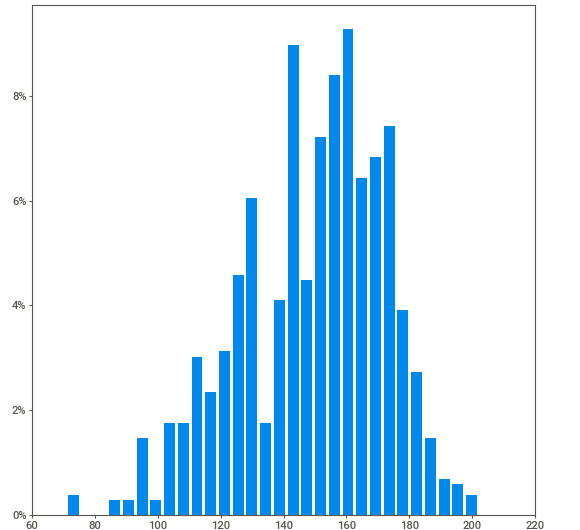
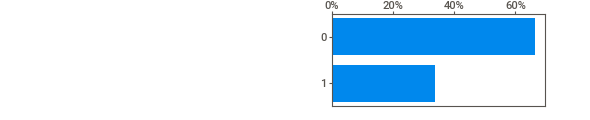
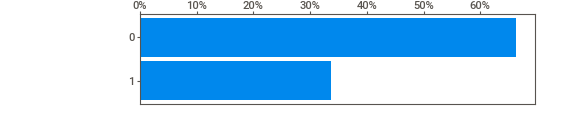
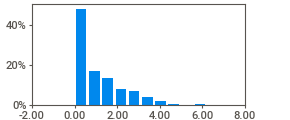
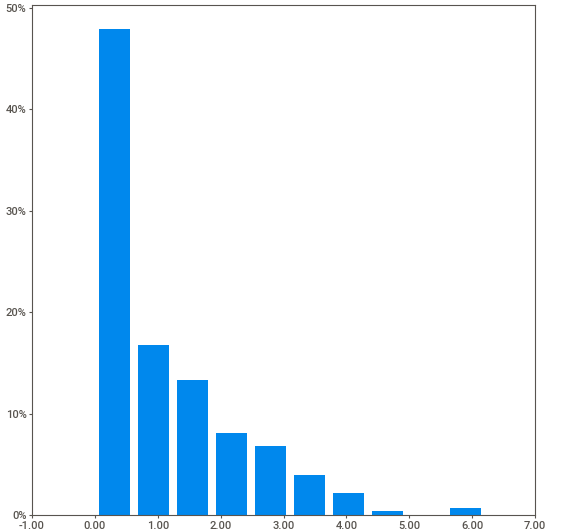
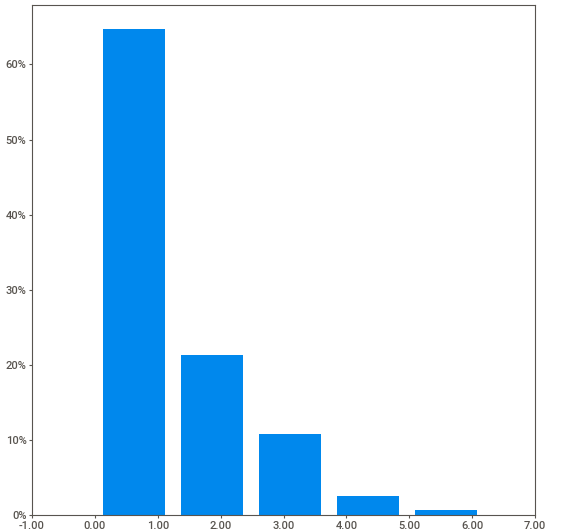
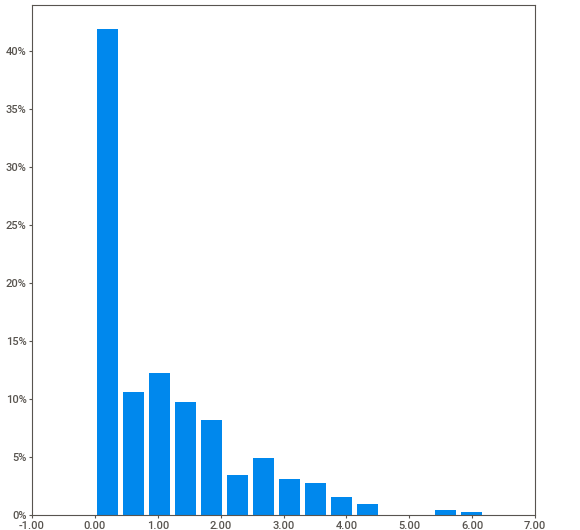
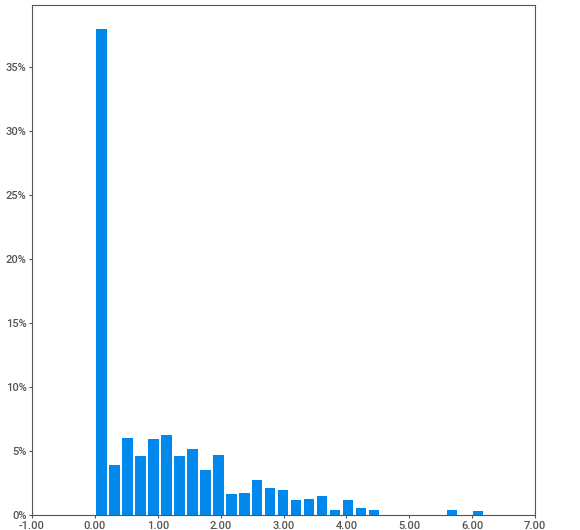
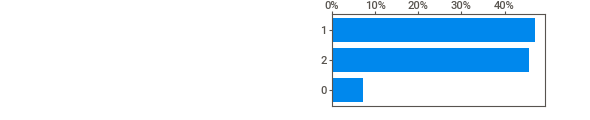
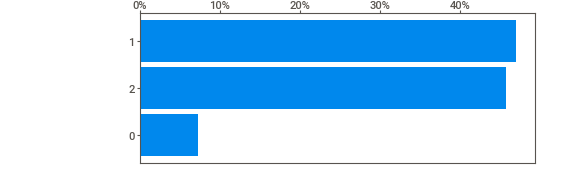
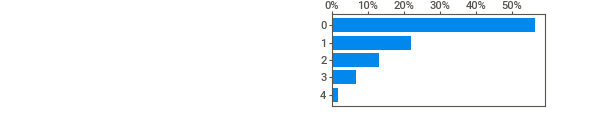
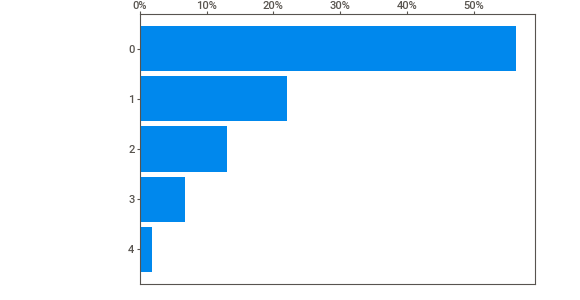
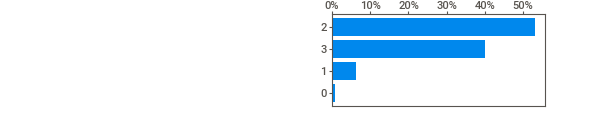
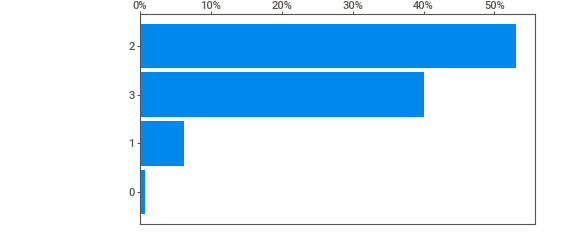
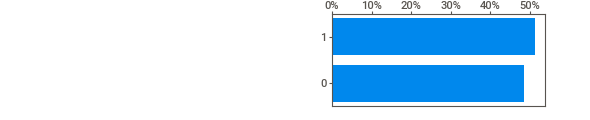
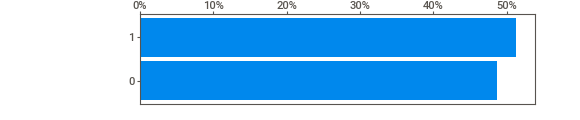
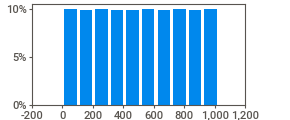
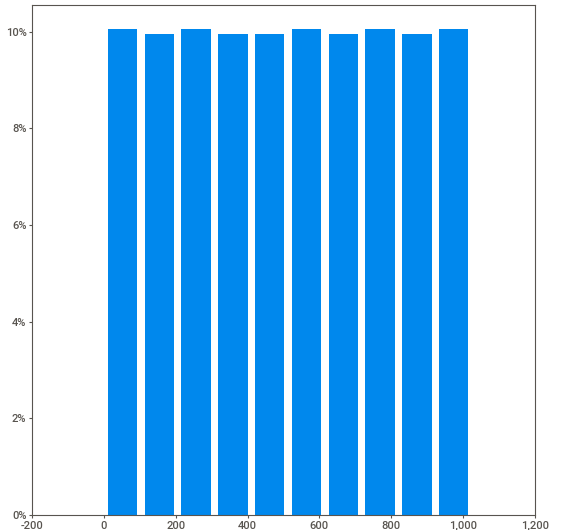
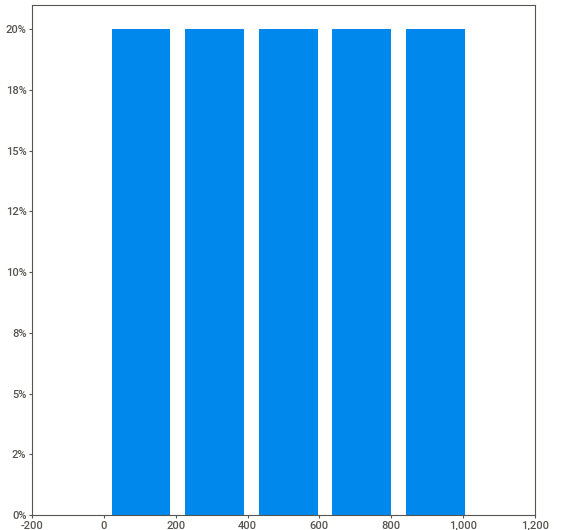
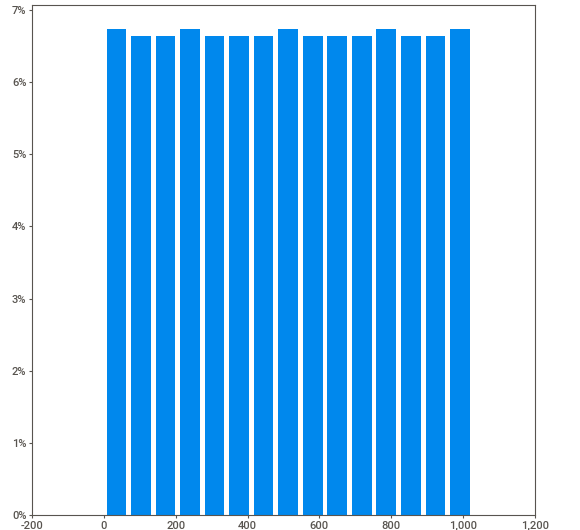
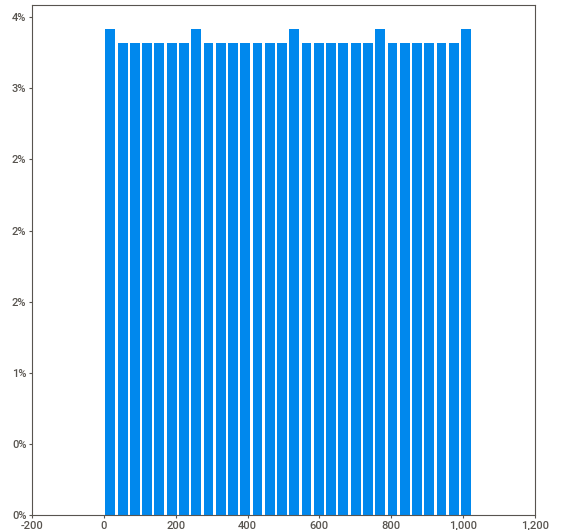
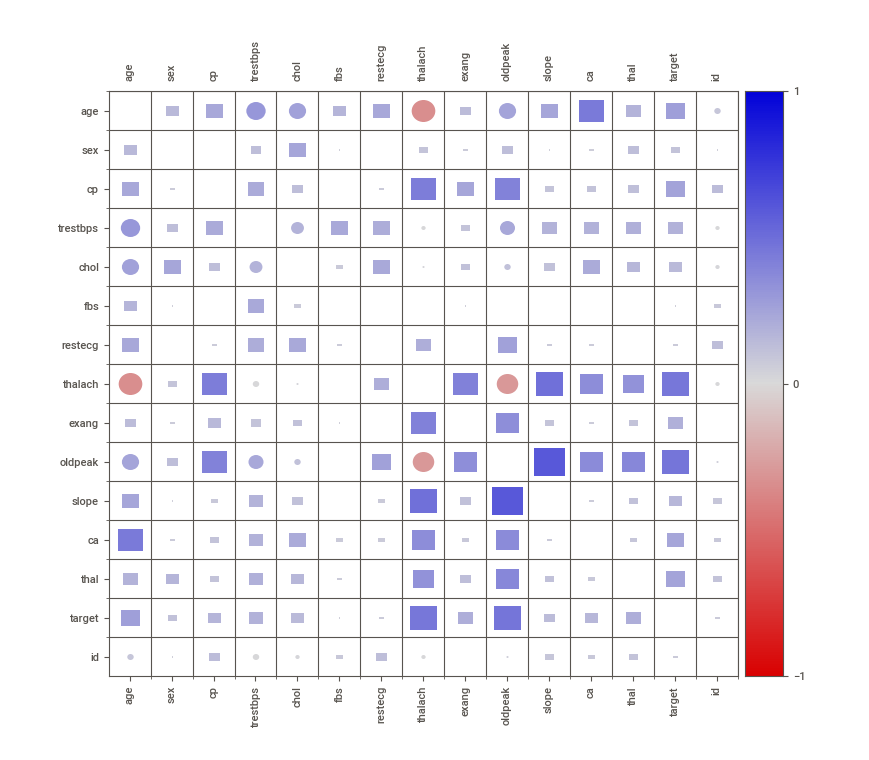
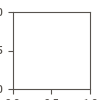

In [64]:
analysis = sv.analyze(dataprep_df)
analysis.show_notebook()

##   5.1 Classificando as colunas do dataset

In [65]:
for i in dataprep_df.columns:
    print(i + ": " + analysis.get_type(i).name)

age: TYPE_NUM
sex: TYPE_BOOL
cp: TYPE_CAT
trestbps: TYPE_NUM
chol: TYPE_NUM
fbs: TYPE_BOOL
restecg: TYPE_CAT
thalach: TYPE_NUM
exang: TYPE_BOOL
oldpeak: TYPE_NUM
slope: TYPE_CAT
ca: TYPE_CAT
thal: TYPE_CAT
target: TYPE_BOOL
id: TYPE_NUM


###   5.2 Separando as colunas classificadas acima como categoricas e numericas:

In [66]:


CAT = ['cp'
,'restecg'
,'slope'
,'ca'
,'thal'
,'sex'
,'fbs'
,'exang'
,'thal'
       
      ]

NUM = ['age'
,'trestbps'
,'chol'
,'thalach'
,'oldpeak'
       
      ]
selected_features = CAT + NUM

In [67]:
# Mudando as colunas numericas para o mesmo tipo (float)
for col_name in NUM:
    dataprep_df[col_name] = dataprep_df[col_name].astype(float)

# Mudando as colunas categoricas para o mesmo tipo (string)
for col_name in CAT:
    dataprep_df[col_name] = dataprep_df[col_name].astype(str)

## 5.3 Analisando os Outliers com o auculio dos graficos Box plot and Violin Plot

In [68]:
def plot_comparison(x, title):
    fig, ax = plt.subplots(3, 1, sharex=True, constrained_layout=True, figsize=(15,5))
    fig.suptitle(title, fontsize=16)
    sns.distplot(x.rename(""), ax=ax[0])
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x.rename(""), ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x.rename(""), ax=ax[2])
    ax[2].set_title('Violin plot')
    plt.show()

age


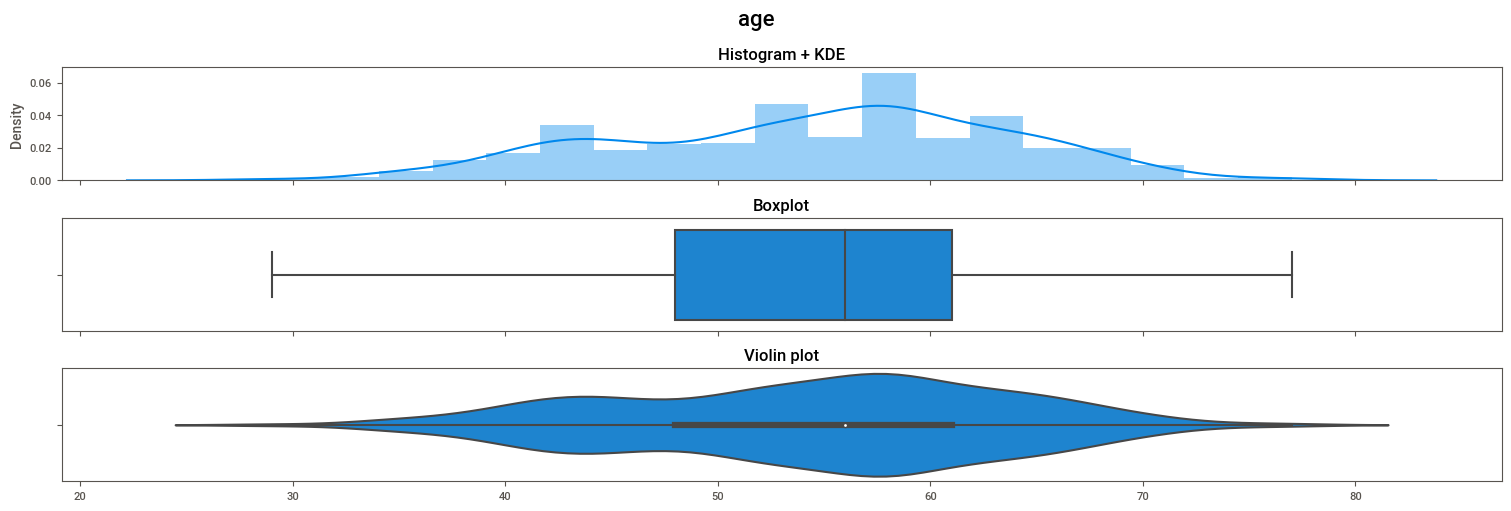

trestbps


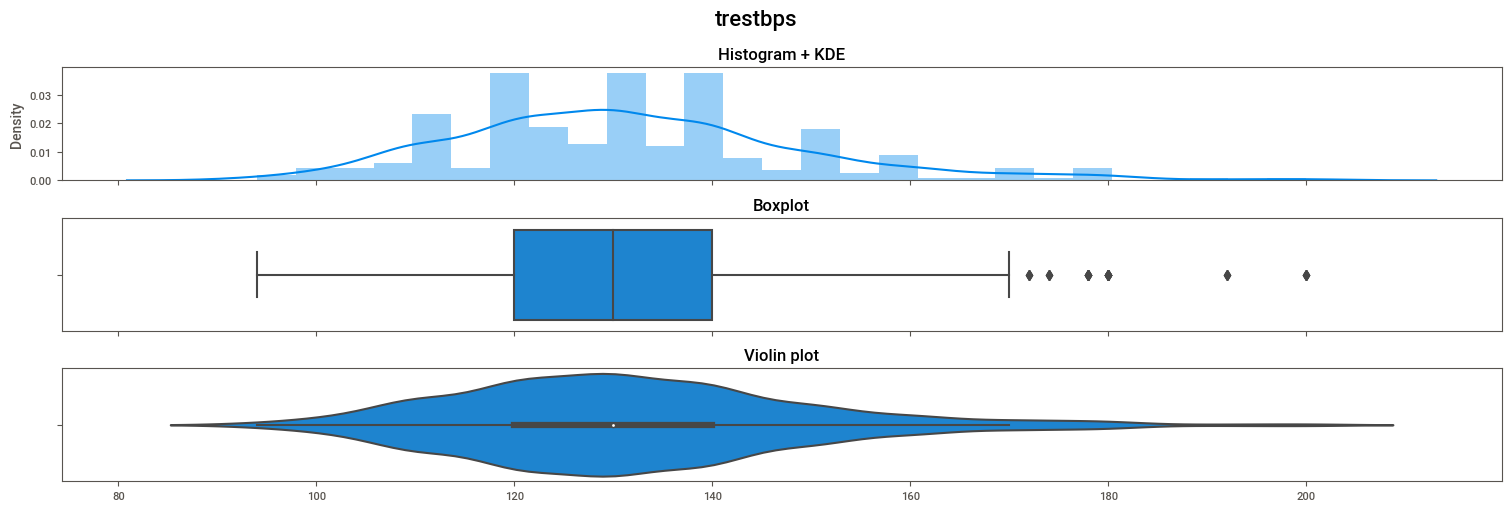

chol


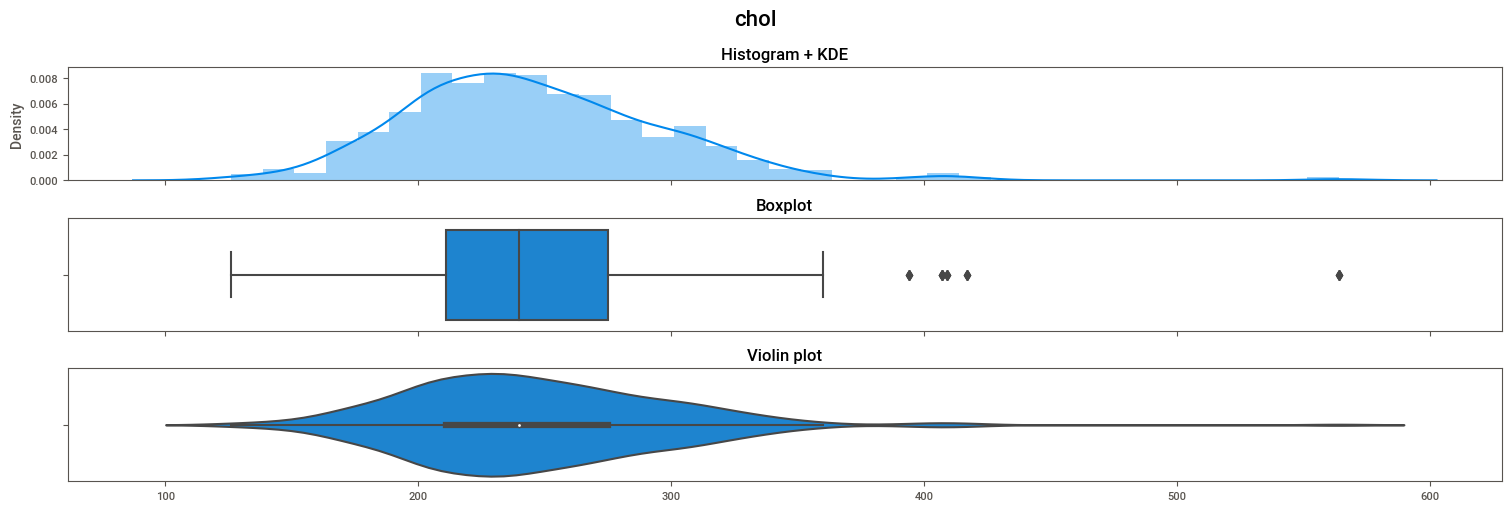

thalach


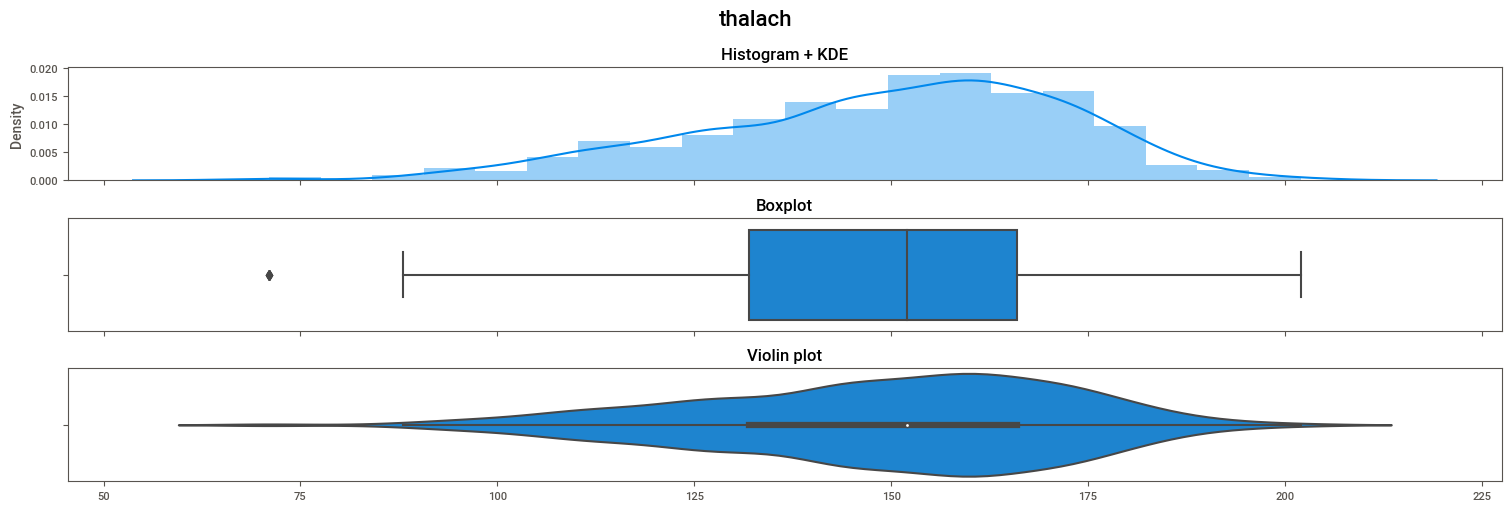

oldpeak


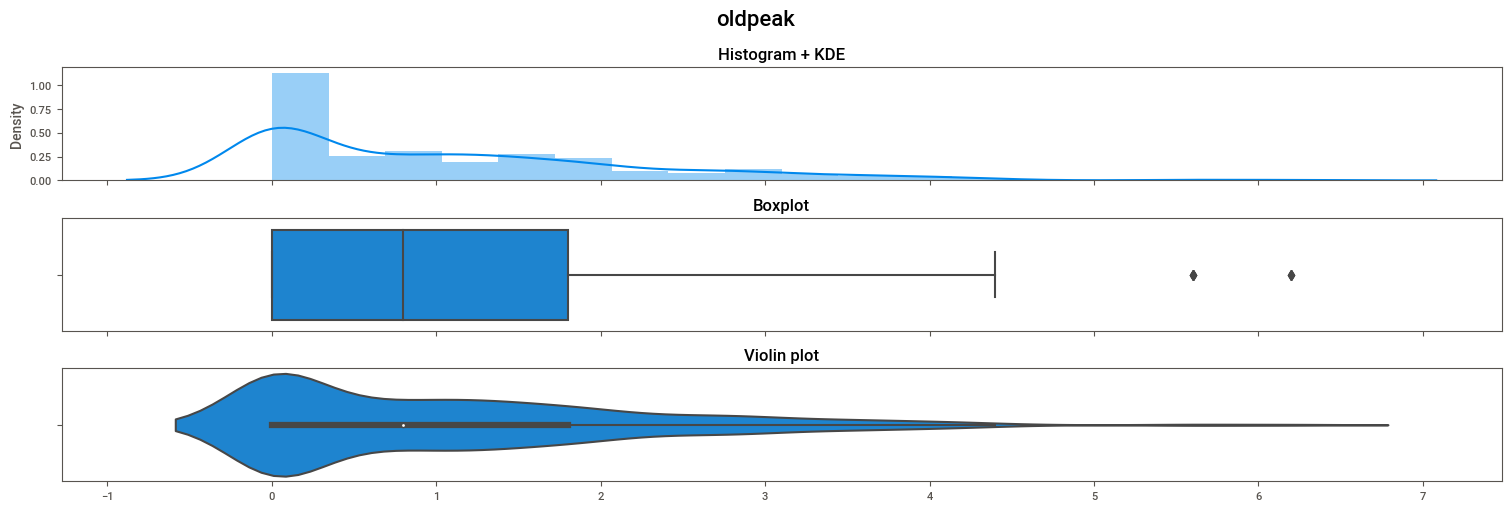

In [69]:
## Distribution analysis of numerical variables
for i in NUM:
    print(i)
    plot_comparison(dataprep_df[i], i)

# 6. Analise Bivariada

## 6.1 Calculando os valores da informacao (IV) para todas as features

In [70]:
def calculate_IV(dataframe, coluna_feature, coluna_target, cat_goods = None, buckets=20):
    
    
    # Definindo o dataset e inicalizando a variavel tpVar
    df = dataframe.loc[:,(coluna_feature, coluna_target)]
    tpVar = 'categorical'    
    
    # Criando categorias para as variaveis numericas
    if df[coluna_feature].dtype=='float64' or df[coluna_feature].dtype=='float32':
        tpVar='numeric'
        coluna_feature_bucket = coluna_feature + "_bucket"
        
        # Criando buckets utillizando o metodo qcut do pandas para as variaveis numericas
        df[coluna_feature_bucket] = pd.qcut(df[coluna_feature], buckets, labels=False, duplicates='drop')
        analyse_df = df.groupby(coluna_feature_bucket, dropna=False).agg({coluna_target: ['count', 'sum'], coluna_feature: ['min', 'max']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    # Criando buckets utillizando o metodo qcut do pandas para as variaveis categoricas
    if tpVar == 'categorical':
        analyse_df = df.groupby(coluna_feature, dropna=False).agg({coluna_target: ['count', 'sum']})
        analyse_df.columns = ['_'.join(tup).rstrip('_') for tup in analyse_df.columns.values]
        analyse_df.rename(columns={(coluna_target+'_count'):'qty', (coluna_target+'_sum'):'qty_goods'}, inplace=True)
        
    # Calculando os IV
    analyse_df.loc[:, 'qty_bads'] = analyse_df.loc[:,'qty'] - analyse_df.loc[:,'qty_goods']
    analyse_df.loc[:, 'tot_goods'] = analyse_df.loc[:,'qty_goods'].sum()
    analyse_df.loc[:, 'tot_bads'] = analyse_df.loc[:,'qty_bads'].sum()
    analyse_df.loc[:, 'perc_goods'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'tot_goods']
    analyse_df.loc[:, 'perc_bads'] = analyse_df.loc[:,'qty_bads'] / analyse_df.loc[:,'tot_bads']
    analyse_df.loc[:, 'good_rate'] = analyse_df.loc[:,'qty_goods'] / analyse_df.loc[:,'qty']
    analyse_df.loc[:, 'odds'] = analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']
    try:
        analyse_df.loc[:, 'ln_odds'] = np.log2(analyse_df['odds'])
    except:
        analyse_df.loc[:, 'ln_odds'] = 0
    analyse_df.loc[:, 'iv_cat'] = (analyse_df.loc[:,'perc_goods'] / analyse_df.loc[:,'perc_bads']) * analyse_df.loc[:, 'ln_odds']
    
    # Criando tabela com as features
    if tpVar == 'numeric':
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature_bucket, coluna_feature+"_min", coluna_feature+"_max", 'qty', 'good_rate', 'odds', 'iv_cat')]
    else:
        analyse_df.reset_index(inplace=True)
        tabela_pdf = analyse_df.loc[:, (coluna_feature, 'qty', 'good_rate', 'odds', 'iv_cat')]
        
    # Criando um dataframe com os valores das features
    df_iv = tabela_pdf.query('iv_cat != inf')['iv_cat'].sum()
    # Retorna a tabela com as features e o dataframe com os valores
    resultado = [df_iv, tabela_pdf]
    return resultado

# Metodo para separar as colunas selecionadas do dataframe original 
def colunas_dataframe(dataframe):
    lista_colunas = []
    lista_colunas = [i for i in dataframe.columns if i in selected_features]
    return lista_colunas

# Metodo para pegar os resulatados de cada colunas  
def table_iv(dataframe):
    lista_colunas = colunas_dataframe(dataframe)
    dict_resultados = {}
    for col in lista_colunas:            
        dict_resultados[col] = calculate_IV(dataframe=dataframe, coluna_feature=col, coluna_target=VarTarget, buckets=10)
    return dict_resultados

## 6.2 Criando dataframe ja setado para plotar o grafico com os IV para todas as features

In [71]:
start = dt.datetime.now()

result_data = table_iv(dataprep_df)
result_formated = pd.DataFrame.from_dict(data=result_data, orient='index').reset_index().rename(columns={'index': 'Variable', 0: 'IV'}).drop(columns=1)
result_formated_graph = result_formated.sort_values(by=['IV'], ascending=False)
                                                                                                                 
#Execution time
stop = dt.datetime.now()
execution_time = stop-start
print("\n"+"Execution time: " + str (execution_time)+"\n")


Execution time: 0:00:00.163041



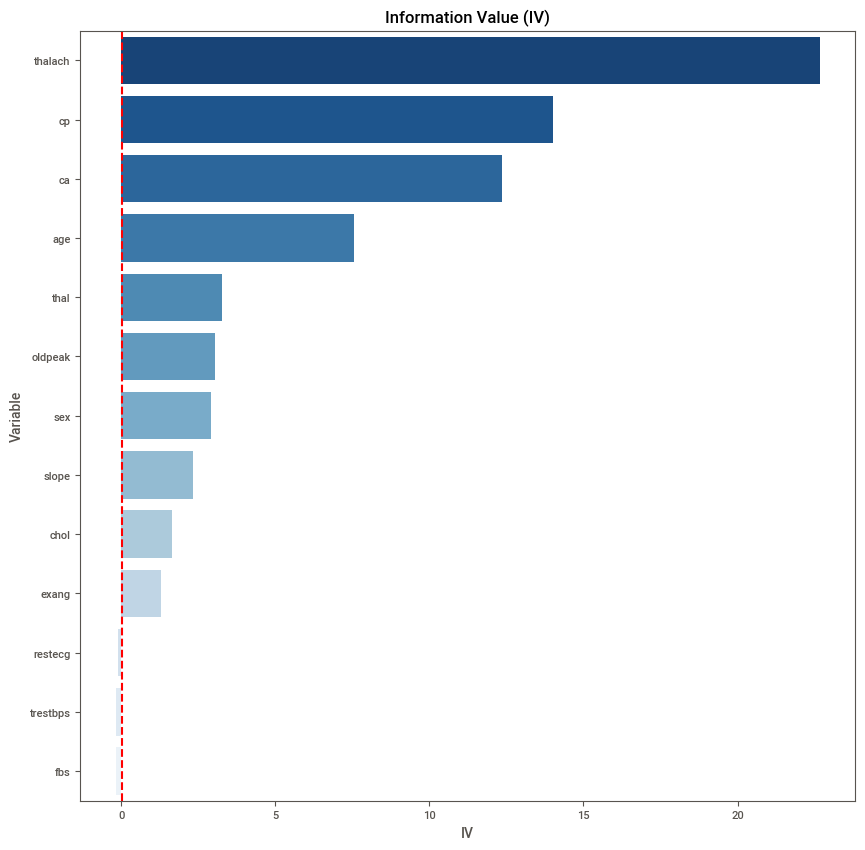

In [72]:
fig = plt.figure(figsize=(10,10))
sns.barplot(y="Variable", x="IV", data=result_formated_graph.head(40), palette="Blues_r").set_title("Information Value (IV)")
plt.axvline (x=0.02, linestyle="--", color='r')

## 6.3  Criando graficos para mostrar a taxa do target (% do target = Doente) por categoria ou range de valor das variaveis categoricas

--------------------------------------- cp


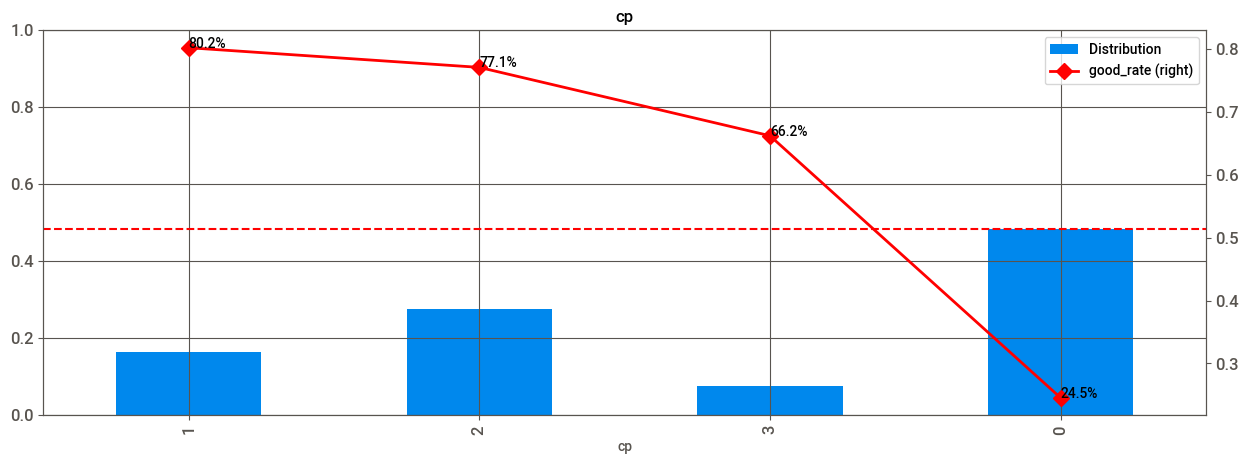

--------------------------------------- restecg


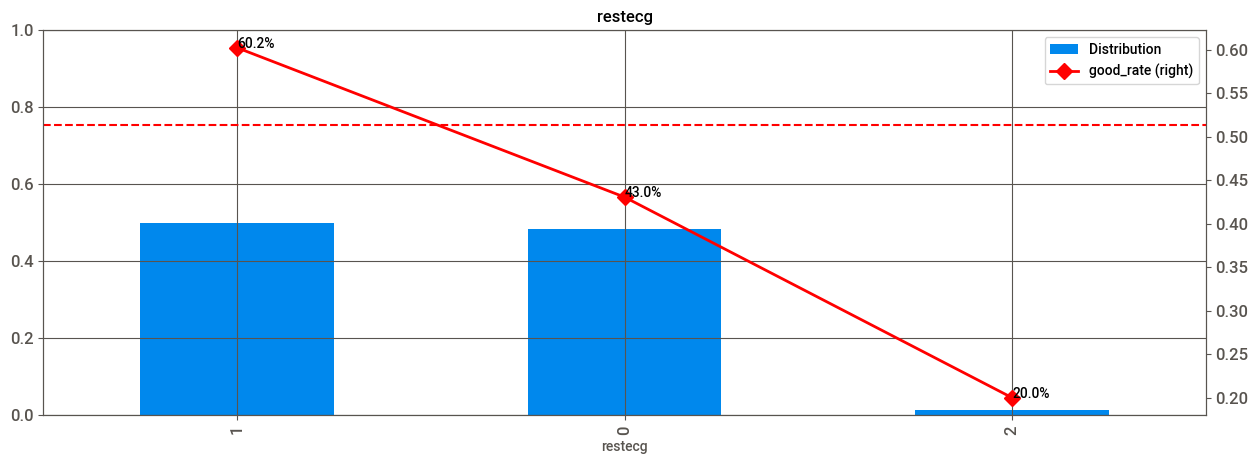

--------------------------------------- slope


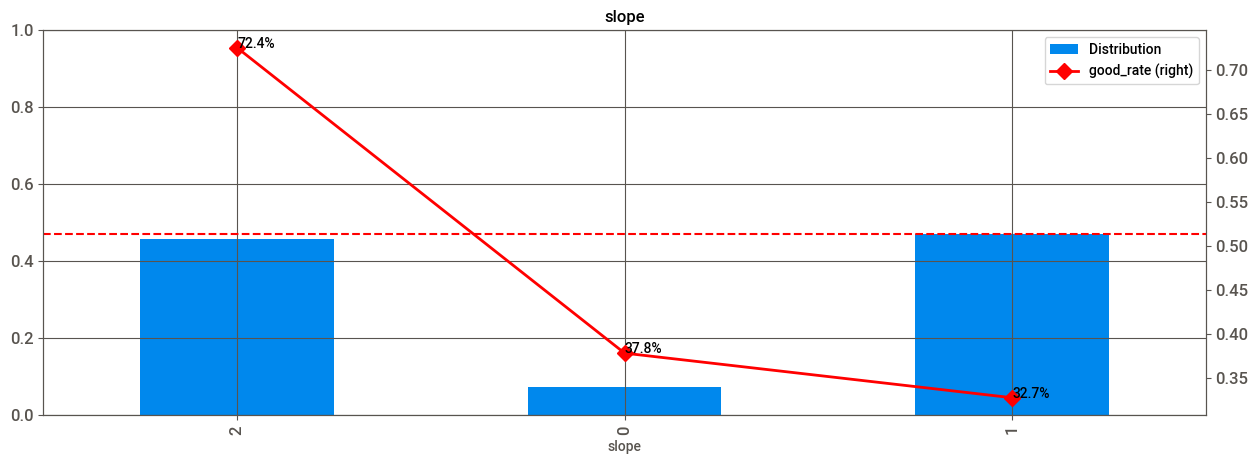

--------------------------------------- ca


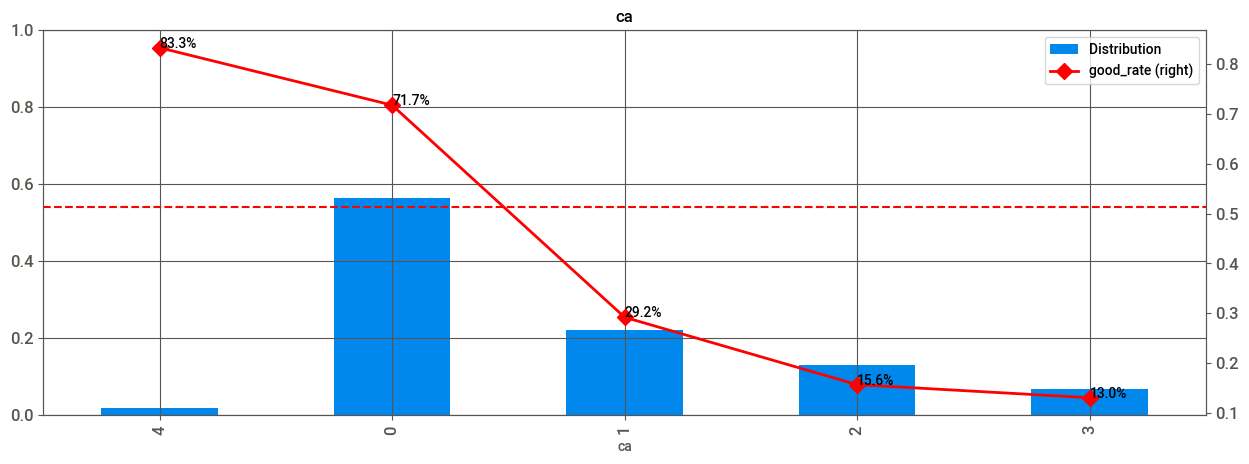

--------------------------------------- thal


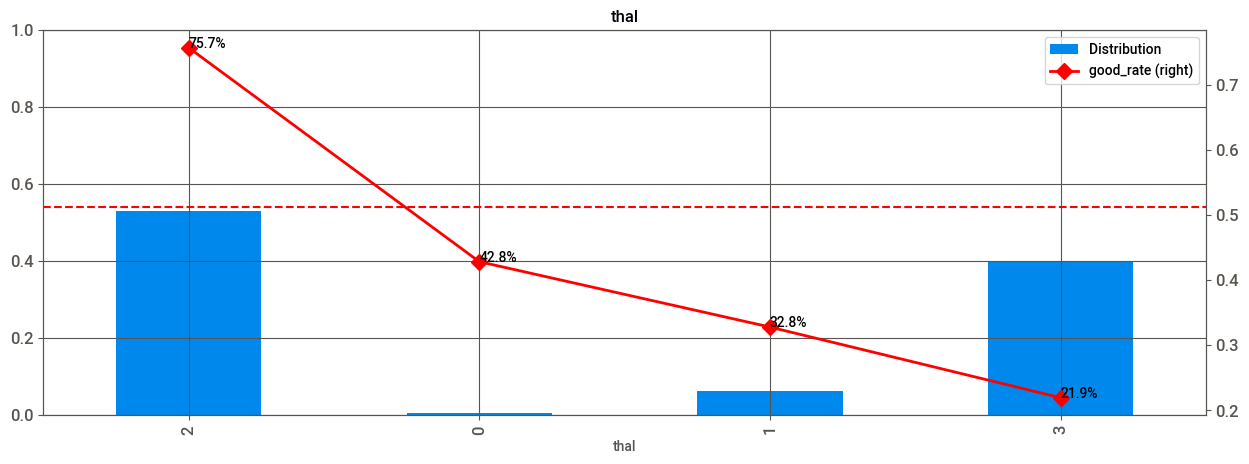

--------------------------------------- sex


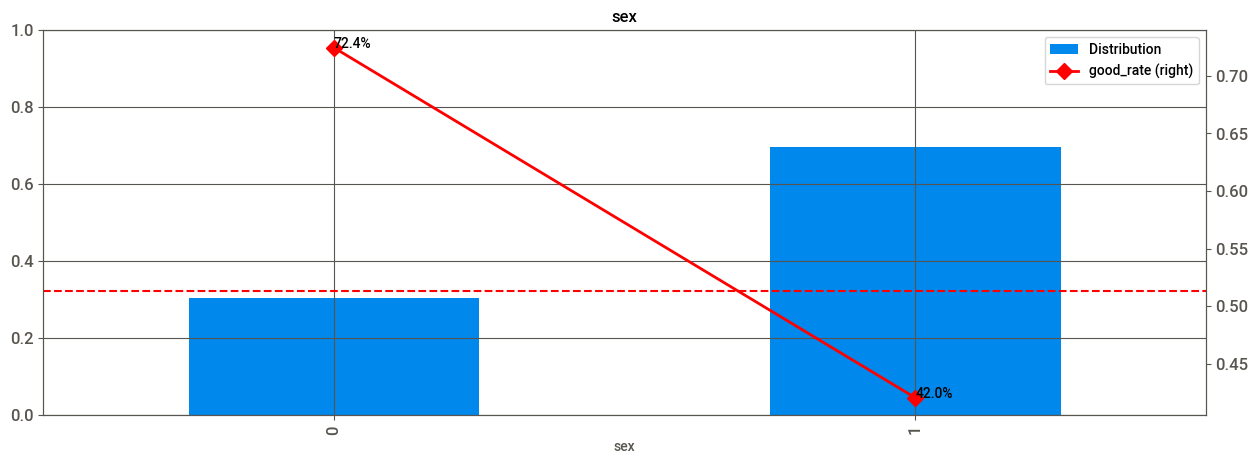

--------------------------------------- fbs


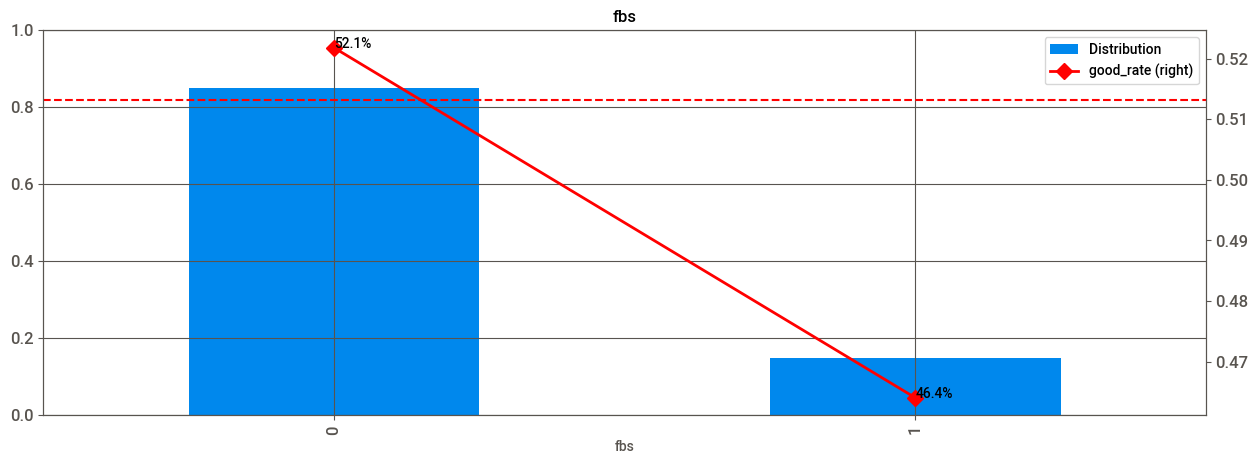

--------------------------------------- exang


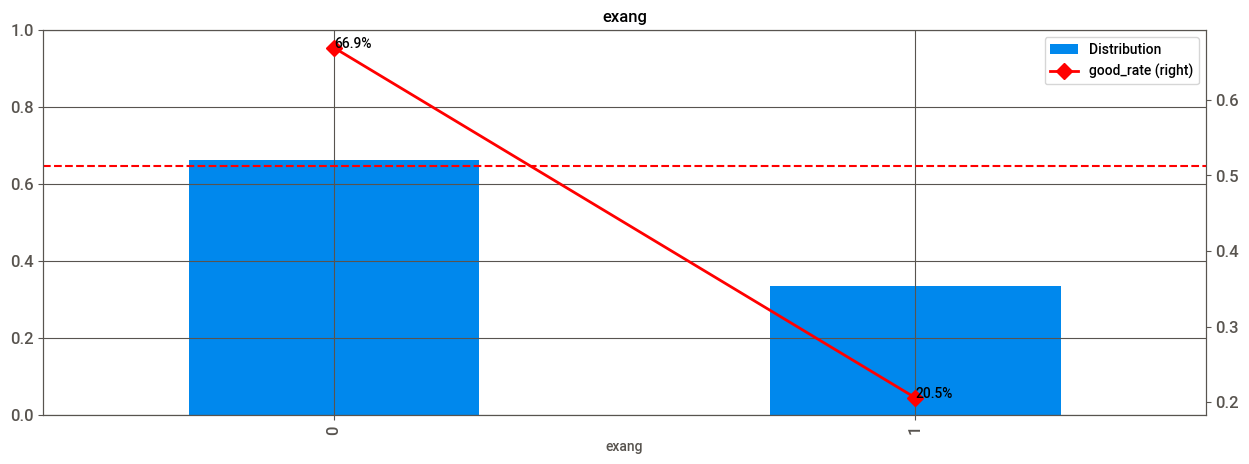

--------------------------------------- thal


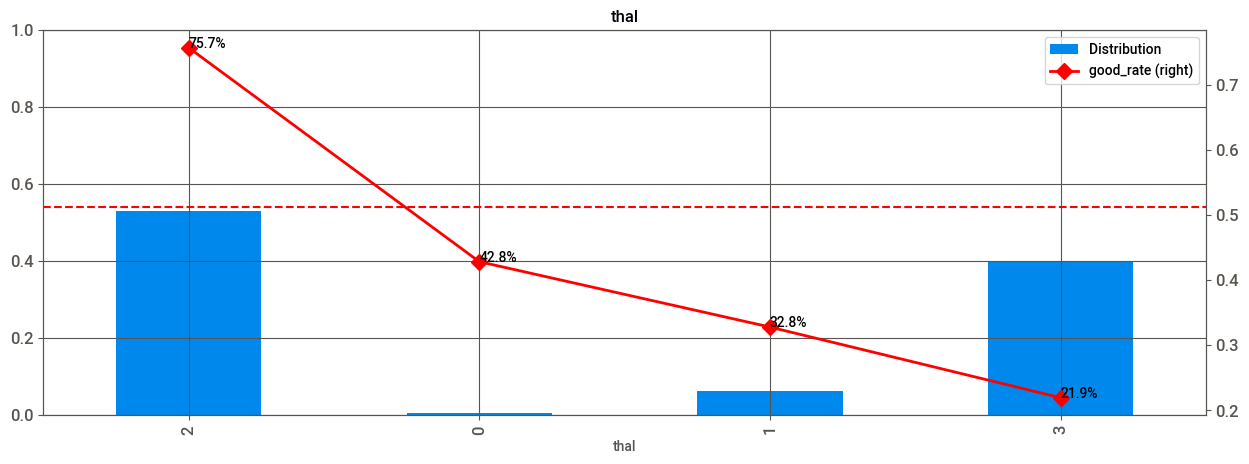

--------------------------------------- age


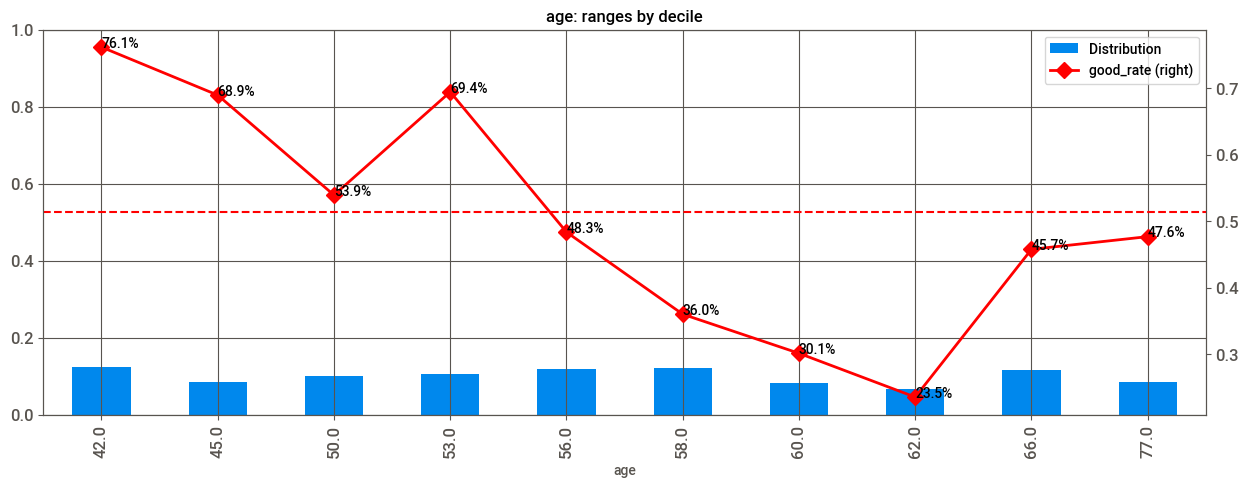

--------------------------------------- trestbps


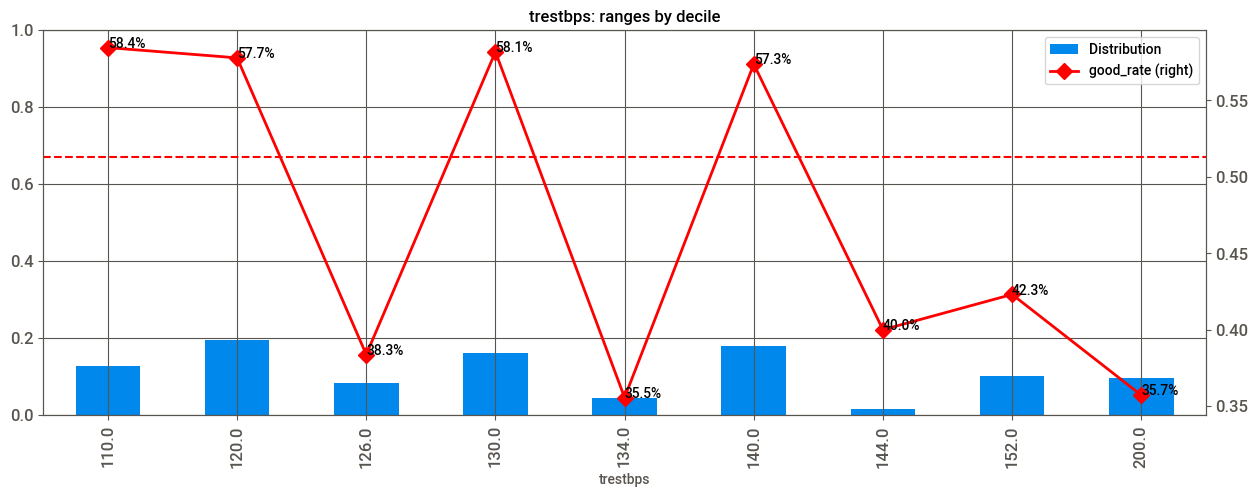

--------------------------------------- chol


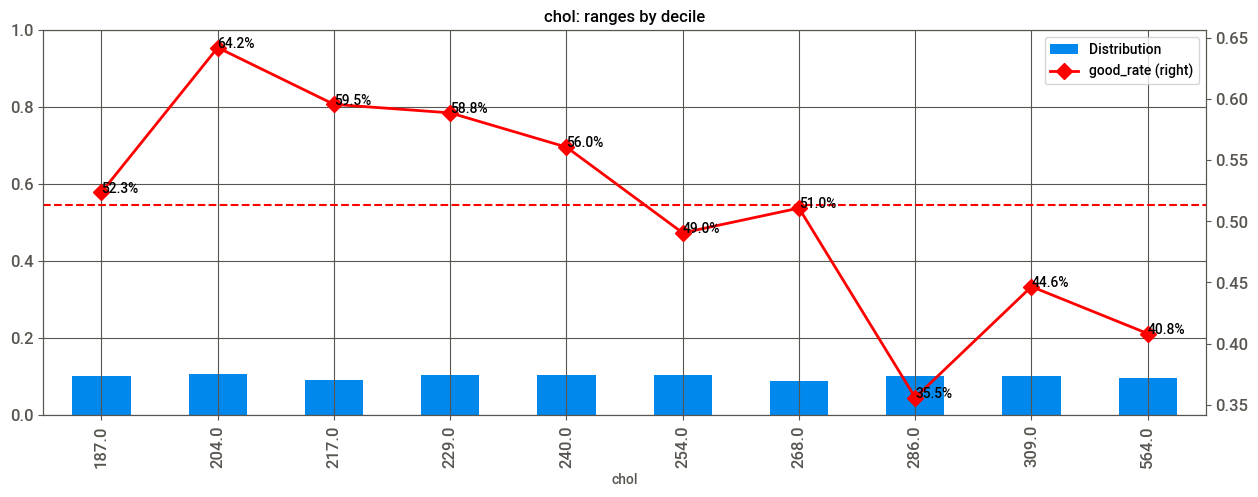

--------------------------------------- thalach


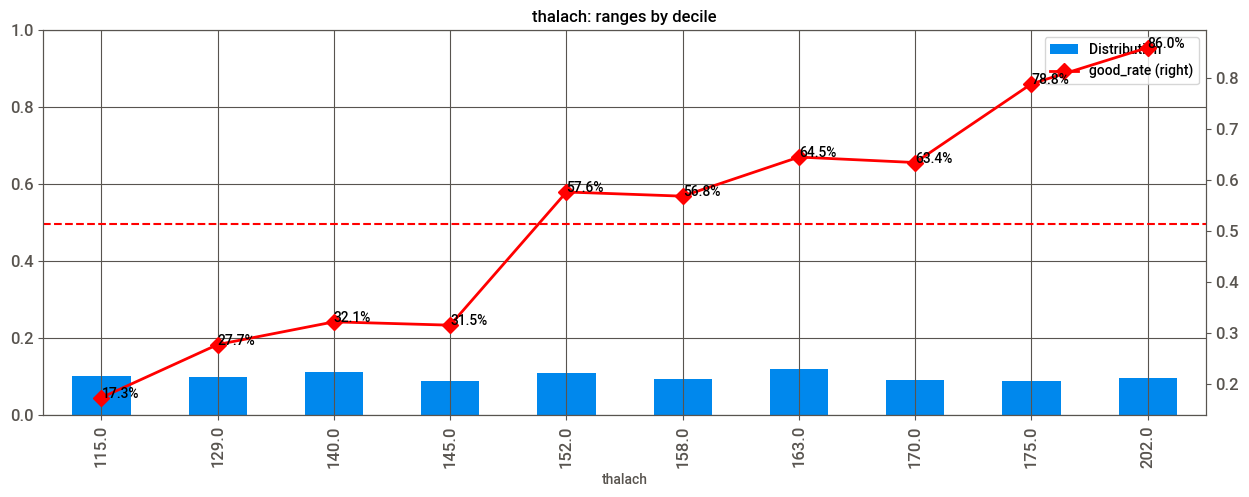

--------------------------------------- oldpeak


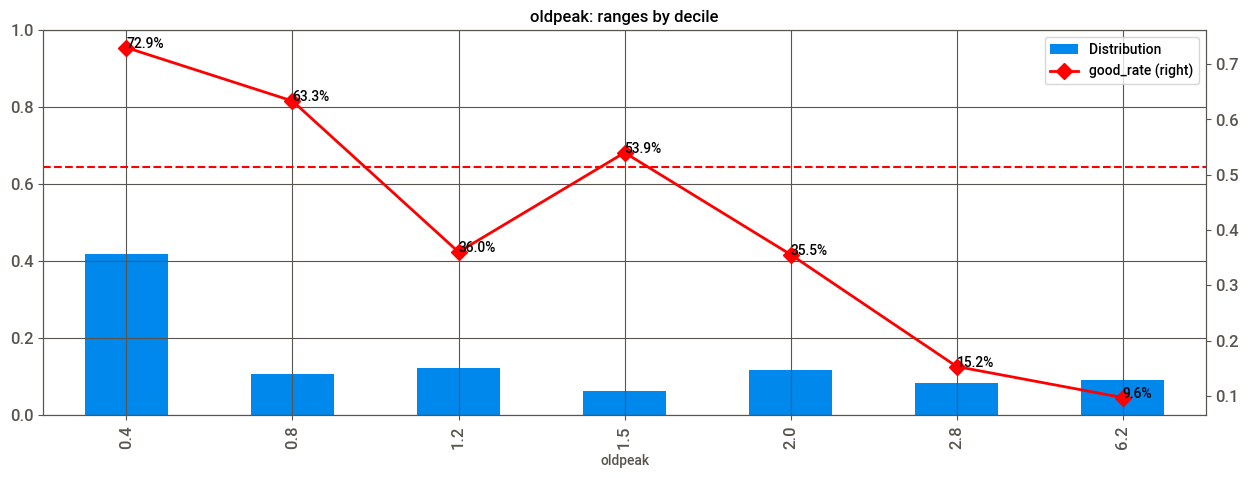

In [73]:
for i in selected_features:
    df_plot_tmp = result_data[i][1]
    df_plot_tmp['Distribution'] = df_plot_tmp.qty / df_plot_tmp.qty.sum()
    if i in CAT:
        print('--------------------------------------- ' + str(i))
        df_plot_tmp = df_plot_tmp.sort_values(by='good_rate', ascending=False)
        df_plot_t1 = df_plot_tmp.loc[:, (i,'Distribution')]
        df_plot_t1 = df_plot_t1.set_index(i)
        df_plot_t2 = df_plot_tmp.loc[:, (i, 'good_rate')]
        df_plot_t2 = df_plot_t2.set_index(i)
        df_plot_t1.Distribution.plot(ylim=[0,1], kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=i)
        ax = df_plot_t2.good_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12\
                                       , marker="D", ms=8, grid=True, color='r', legend=1)
        for p in range(len(df_plot_t2)):
            ax.annotate(str('{0:.1%}'.format(int(df_plot_t2.reset_index().iloc[p,1]*1000)/1000))\
                            ,(df_plot_t2.reset_index().index.values[p]\
                              ,df_plot_t2.reset_index().iloc[p,1]*1))
        target_mean = sum(df_plot_tmp.qty * df_plot_tmp.good_rate) / sum(df_plot_tmp.qty)
        ax.axhline(y=target_mean, color='r', linestyle='--')
        plt.show()

    else:
        sort_var = str(i)+"_max"
        print('--------------------------------------- ' + str(i))
        df_plot_tmp[sort_var] = df_plot_tmp[sort_var].astype(float)
        df_plot_tmp = df_plot_tmp.sort_values(by=sort_var)
        df_plot_tmp[i] = df_plot_tmp[sort_var].fillna(999999999.99).astype(float)
        df_plot_tmp[i] = (df_plot_tmp[i]*100).astype(int)/100
        df_plot_tmp[i] = df_plot_tmp[i].astype(str).replace("999999999.99", "missing")
        df_plot_t1 = df_plot_tmp.loc[:, (i, 'Distribution')]
        df_plot_t1 = df_plot_t1.set_index(i)
        df_plot_t2 = df_plot_tmp.loc[:, (i, 'good_rate')]
        df_plot_t2 = df_plot_t2.set_index(i)
        df_plot_t1.Distribution.plot(ylim=[0,1], kind='bar', rot=90, figsize=(15,5), linewidth=2, fontsize=12, grid=True, legend=1, title=(i + ": ranges by decile"))
        ax = df_plot_t2.good_rate.plot(secondary_y=True, kind="line", rot=90, figsize=(15,5), linewidth=2, fontsize=12, marker="D", ms=8, grid=True, color='r', legend=1)
        for p in range(len(df_plot_t2)):
            ax.annotate(str('{0:.1%}'.format(int(df_plot_t2.reset_index().iloc[p,1]*1000)/1000)), (df_plot_t2.reset_index().index.values[p], df_plot_t2.reset_index().iloc[p,1]*1))        
        target_mean = sum(df_plot_tmp.qty * df_plot_tmp.good_rate) / sum(df_plot_tmp.qty)
        ax.axhline(y=target_mean, color='r', linestyle='--')
        plt.show()
        #display(ax)

# 7. Salvando o dataset final para o bucket criado no AWS S3

##    7.1 Padronizando os dados das features numericas

In [74]:
X = dataprep_df.drop(['cp','restecg','slope','ca','thal','sex','fbs','exang','thal', 'target','id'], axis =1)
X_col = X.columns

In [75]:
scaler =  StandardScaler()
X_pdr = scaler.fit_transform(X)

In [76]:
dataprep_df.loc[:,X_col] = X_pdr
dataprep_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,id
0,-0.268437,1,0,-0.377636,-0.659332,0,1,0.821321,0,-0.060888,2,2,3,0,1
1,-0.158157,1,0,0.479107,-0.833861,1,0,0.255968,1,1.727137,0,0,3,0,2
2,1.716595,1,0,0.764688,-1.396233,0,1,-1.048692,1,1.301417,0,0,3,0,3
3,0.724079,1,0,0.936037,-0.833861,0,1,0.516900,0,-0.912329,2,1,3,0,4
4,0.834359,0,0,0.364875,0.930822,1,1,-1.874977,0,0.705408,1,3,2,0,5


##    7.2 Salvando no S3

In [77]:
#Create boto3 sesesion for Athena, SageMaker and S3 connection
my_boto3_session = boto3.Session(region_name='us-east-1')


In [78]:
 test, train = train_test_split(dataprep_df, test_size = 0.4, random_state = 0)

In [79]:
csv_buffer = StringIO()
train.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/train_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer

csv_buffer = StringIO()
test.to_csv(csv_buffer, index=False, header=True)
s3_resource = my_boto3_session.resource('s3')
s3_resource.Object(bucket, 'databases/%s/test_data.csv' % ModelName).put(Body=csv_buffer.getvalue())
del csv_buffer